In [1]:
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import *
from scipy.linalg import sqrtm
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.manifold import *
from sklearn.preprocessing import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.neighbors import KNeighborsClassifier
import pickle
from catboost import *
import gc
from collections import *

Оставим лишь те колонки, которые были в обучающей выборке

In [16]:
columns = pickle.load(open("../input/train-all-fill/columns.pkl", "rb"))
data_test = pd.read_parquet("../input/amex-parquet-test-int/test.parquet", columns = columns)

In [7]:
types = dict(data.dtypes)

for feature in types.keys():
    if types[feature] == np.int64:
        data[feature] = data[feature].astype(np.int16)
    elif types[feature] == np.float64:
        data[feature] = data[feature].astype(np.float32)

In [14]:
cat_features  = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
cat_features = [feature for feature in cat_features if feature in data.columns]
real_features = [feature for feature in data.columns if feature not in cat_features]

Counter({13: 214216,
         12: 4302,
         9: 2792,
         10: 2632,
         11: 2571,
         7: 2546,
         8: 2533,
         6: 2298,
         5: 2212,
         4: 2210,
         2: 2163,
         3: 2080,
         1: 1502})


Text(0.5, 1.0, 'Distribution of months count')

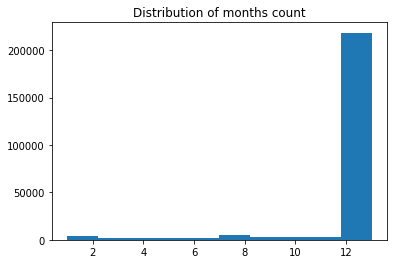

In [6]:
#Распределение количества известных месяцев о пользователе

index_count = Counter(data.index)

pprint(Counter(index_count.values()))

plt.hist(index_count.values())
plt.title("Distribution of months count")

Заполним линейной интерполяцией вещественные признаки внутри каждого индекса

In [6]:
def fill_missing_real(data, index_count):
    row = 0
    
    indexes = data.index
    columns = data.columns
    
    data = data.to_numpy(dtype = np.float32)
    
    curr_part = 0
    
    while row < data.shape[0]:
        
        index = indexes[row]
                
        curr_count = index_count[index]
                
        data_frame = pd.DataFrame(data[row : row + curr_count])
        
        data_frame = data_frame.interpolate(limit_direction = 'both', limit = 13)
        
        data[row : row + curr_count] = data_frame
            
        row += index_count[index]
        
        if row > data.shape[0] / 10 * curr_part:
            print(row, '/', data.shape[0])
            curr_part += 1
            
    return pd.DataFrame(data, columns = columns, index = indexes)

In [7]:
data[real_features] = fill_missing_real(data[real_features], index_count)

9 / 3363762
336384 / 3363762
672754 / 3363762
1009129 / 3363762
1345512 / 3363762
1681891 / 3363762
2018261 / 3363762
2354642 / 3363762
2691013 / 3363762
3027397 / 3363762


Заполним некоторые признаки их дефолтными значениями

In [9]:
data = pd.read_parquet("../input/amex-test-int-inter/test.parquet")

In [10]:
with open("../input/amex-test-int-inter/target_features.pkl", "rb") as file:
    target_features = pickle.load(file) 
    
with open("../input/amex-test-int-inter/train_features.pkl", "rb") as file:
    train_features  = pickle.load(file)
    
with open("../input/amex-test-int-inter/default_values.pkl", "rb") as file:
    default_values  = pickle.load(file)

In [11]:
def fill_missing_default(data, features, default_values):
    
    for column in features:
        data[column] = data[column].fillna(default_values[column])
        
    return data

data = fill_missing_default(data, train_features, default_values)

In [13]:
def make_repeats(data, index_count, target_count):
    repeats = []
    index = 0
    dobavka = 0
    while index < data.shape[0]:
        curr_count = index_count[data.index[index]]
        ness_count = target_count - curr_count
        ness_el = data.iloc[index + curr_count - 1]
        
        for i in range(ness_count):
            repeats.append(ness_el)
            
        index += curr_count
    
    data = data.append(repeats)
    
    return data.sort_index()
    
    
def fill_missing_by_model(data, model, train_features, target_features, train = True):
    row = 0
            
    mask = data[target_features].notnull()
        
    for feature in tqdm(target_features):
        
        if train:
            train_data = data[train_features][mask[feature]][: data.shape[0] // 3]
            labels     = data[feature][mask[feature]][: data.shape[0] // 3]
        
            model_ = model
        
            model_.fit(train_data, labels)
            
            pickle.dump(model_, open(feature + "_model", "wb"))
            
            del train_data
            del labels
        
        else:
            model_ = pickle.load(open("../input/train-all-fill/" + feature + "_model", 'rb'))
            
        test_data = data[~mask[feature]][train_features]
        
        result = model_.predict(test_data)
        
        
        data[feature][~mask[feature]] = result
    
        del result
        del model_
        gc.collect()
        
    return data       

In [15]:
cat_feature_models  = []
real_feature_models = []

cat_target_features  = [feature for feature in target_features if feature in cat_features]
real_target_features = [feature for feature in target_features if feature in real_features]


data = fill_missing_by_model(data, CatBoostClassifier(iterations = 300), train_features, cat_target_features,  False)

data = fill_missing_by_model(data, CatBoostRegressor(iterations = 300),  train_features, real_target_features, False)

0it [00:00, ?it/s]
  0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 14/14 [01:03<00:00,  4.56s/it]


Создадим target encoder фичи на основе обучающей выборки

In [ ]:
with open("../input/amex-test-int-inter/cat_targets.pkl", "wb") as file:
    cat_targets = pickle.load(file)

In [18]:
for feature in tqdm(cat_features):
    
    data[feature + "_target"] = data[feature]
    
    data[feature + "_target"] = data[feature + "_target"].replace(cat_targets[feature])

100%|██████████| 9/9 [00:00<00:00,  9.74it/s]


In [ ]:
data = make_repeats(data, index_count, 13)

In [9]:
data = pd.read_parquet("../input/test-all-fill/test1.parquet")[:3_000_003]

In [3]:
def make_repeats(data, index_count, target_count):
    repeats = []
    index = 0
    dobavka = 0
    while index < data.shape[0]:
        curr_count = index_count[data.index[index]]
        ness_count = target_count - curr_count
        ness_el = data.iloc[index + curr_count - 1]
        
        for i in range(ness_count):
            repeats.append(ness_el)
            
        index += curr_count
    
    data = data.append(repeats)
    
    return data.sort_index()

In [10]:
gc.collect()

46

In [ ]:
data = make_repeats(data, index_count, 13)

In [ ]:
data.to_parquet("test2.parquet")